In [3]:
from spad.common import units
from spad import stop_inference
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.cm
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

from IPython.display import display
plt.style.use("figures.mplstyle")
import tikzplotlib as tpl

def legend_out(ax, **kws):
    return ax.legend(loc=2, ncol=1, bbox_to_anchor=[1, 1], **kws)

In [4]:
pings = stop_inference.get_still_pings("postgresql://")

In [5]:
from importlib import reload

In [6]:
reload(stop_inference)

<module 'spad.stop_inference' from '/mnt/tod/projects/spad/src/spad/stop_inference.py'>

In [7]:
ssi = stop_inference.ServiceStopInference(
    v=units("8 mph"),
    d=units("200 feet"),
    t=units("5 minutes"),
    n_pings=5,
    trip_travel_distance=units("3 miles"),
    trip_travel_time=units("20 minutes"),
)

In [8]:
data = []
for _, g in pings.groupby(["driver_id"]):
    data.append(ssi.infer_stops(g))
inferred_stops = pd.concat(data)

In [9]:
def count_stops(stops):
    n = (stops.p_same_stop_as_next.fillna(1.0) < 0.5).cumsum()
    n[stops.p_service_stop < 0.5] = np.nan 
    return n.rank(method="dense", ascending=False)

In [10]:
stops = pings.join(inferred_stops)
stops["driver_id"] = stops["driver_id"].apply(str)

In [11]:
stops["stop_count"] = stops.sort_values("localized_timestamp", ascending=False
             ).groupby("driver_id").apply(count_stops).reset_index("driver_id", drop=True)

In [12]:
top_drivers = stops.groupby("driver_id").size().sort_values(ascending=False)

In [13]:
top_drivers[top_drivers > 100]

driver_id
22cc59f5-c569-4ccd-9c27-d841a0e88486    356144
4795bb78-f0a3-4ce2-98c6-3f0b11166014    150040
d909cfec-4107-45f0-b18f-042ba5e051ad     70347
ac97bf7e-1daa-48b4-8a34-fa0c84a25563     69441
24875ef0-474d-4d02-a644-40086ddcf12d     59372
                                         ...  
f42554a4-82d5-4b9b-aa1f-8116af337e1a       110
2ad92a35-50e0-4e73-b4a7-9a8c6511c9ef       108
76a74dc3-fd7e-490d-851c-908797891796       108
9107141f-1061-46ef-bf64-48713224f38f       105
3fd36a7f-08b3-4c09-8f76-830e3410a6f0       101
Length: 397, dtype: int64

In [14]:
driver_id = '3fd36a7f-08b3-4c09-8f76-830e3410a6f0'

In [15]:
stops[stops.driver_id == driver_id].astype({"localized_timestamp": str,}
                                          ).explore("stop_count",
                                                    cmap=[to_hex(c) for c in matplotlib.cm.get_cmap("tab10").colors], categorical=True,
                                                    tooltip=True, popup=True,
)

In [16]:
stops[(stops.driver_id == driver_id)].sort_values(by="localized_timestamp")

,driver_id,shift_id,localized_timestamp,speed,activity_confidence,dt_seconds,dx_meters,geometry,p_service_stop,p_same_stop_as_next,stop_count
id,,,,,,,,,,,
34043600,3fd36a7f-08b3-4c09-8f76-830e3410a6f0,683408,2020-08-01 17:42:11.000,0.59,100.0,1.000,0.559356,POINT (-80.27255 40.16475),0.951952,1.0,1.0
159322108,3fd36a7f-08b3-4c09-8f76-830e3410a6f0,683408,2020-08-01 17:42:12.000,0.25,100.0,21.806,10.235058,POINT (-80.27255 40.16474),0.965321,1.0,1.0
146082647,3fd36a7f-08b3-4c09-8f76-830e3410a6f0,683408,2020-08-01 17:42:33.806,1.25,100.0,10.194,11.552357,POINT (-80.27266 40.16478),0.911034,1.0,1.0
134611667,3fd36a7f-08b3-4c09-8f76-830e3410a6f0,683408,2020-08-01 17:42:44.000,0.09,100.0,30.000,13.643748,POINT (-80.27258 40.16470),0.970296,1.0,1.0
6671152,3fd36a7f-08b3-4c09-8f76-830e3410a6f0,683408,2020-08-01 17:43:14.000,6.73,100.0,78.000,19.402556,POINT (-80.27259 40.16482),0.040947,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
140787593,3fd36a7f-08b3-4c09-8f76-830e3410a6f0,781325,2020-09-03 16:08:12.000,1.29,100.0,7.000,10.808185,POINT (-80.04971 40.35572),0.907738,1.0,10.0
152261330,3fd36a7f-08b3-4c09-8f76-830e3410a6f0,781325,2020-09-03 16:08:19.000,3.46,100.0,1854.000,1823.999782,POINT (-80.04974 40.35581),0.529047,0.0,10.0
154026136,3fd36a7f-08b3-4c09-8f76-830e3410a6f0,781325,2020-09-03 16:39:13.000,0.45,100.0,20.000,10.318587,POINT (-80.02880 40.35945),0.957965,1.0,11.0


In [17]:
service_stops = stops.groupby(["driver_id", "stop_count"]).agg(
    localtime_start=("localized_timestamp", "min"),
    localtime_end=("localized_timestamp", "max"),
    n_pings=("localized_timestamp", "count"),
    geometry=("geometry", lambda gs: gs.unary_union)
)

In [18]:
service_stops = gpd.GeoDataFrame(service_stops, geometry="geometry", crs=stops.geometry.crs)

In [19]:
service_stops["stop_hull"] = service_stops.convex_hull
service_stops.set_geometry("stop_hull", inplace=True)

In [20]:
service_stops.xs(driver_id, level="driver_id").reset_index().astype({"localtime_start": str, "localtime_end": str}).explore("stop_count", categorical=True, tooltip=["stop_count"], popup=["stop_count"])

In [21]:
utm_crs = service_stops.geometry.estimate_utm_crs()
service_stops.to_crs(utm_crs).centroid.buffer(75.0)

driver_id                             stop_count
01077008-15a7-44a1-a712-b67e09735380  1.0           POLYGON ((581240.481 4473717.790, 581240.119 4...
                                      2.0           POLYGON ((581241.740 4473727.650, 581241.379 4...
019c9f85-3818-42de-bad6-d556e7ad1949  1.0           POLYGON ((562362.220 4482590.886, 562361.859 4...
                                      2.0           POLYGON ((562362.570 4482590.655, 562362.208 4...
                                      3.0           POLYGON ((562362.438 4482590.210, 562362.077 4...
                                                                          ...                        
ffb3c2d0-67b4-4163-be9d-eca9e7299377  1774.0        POLYGON ((594615.407 4449644.127, 594615.045 4...
                                      1775.0        POLYGON ((594640.298 4449634.390, 594639.937 4...
                                      1776.0        POLYGON ((594623.030 4449641.125, 594622.669 4...
                                 

In [98]:
osm_entities = gpd.read_postgis(
    """select * from osm_entity_tags where tag_name != 'opening_hours' and tag_name != 'service_times'""",
    "postgresql://",
    index_col="osm_id",
    geom_col="geometry")

In [99]:
opening_hours = gpd.read_postgis(
    """select * from osm_entity_tags where tag_name = 'opening_hours' or tag_name = 'service_times'""",
    "postgresql://",
    index_col="osm_id",
    geom_col="geometry"
)

In [121]:
import osm_opening_hours_humanized as hoh
from osm_opening_hours_humanized.exceptions import HOHError
from astral import LocationInfo
pgh = LocationInfo( "Pittsburgh", "PA", "America/New_York", 40.44127718642986, -80.00144481122433)
def try_parse_hours(s, **kwds):
    try:
        return hoh.OHParser(s, **kwds)
    except HOHError:
        return None
opening_hours["hours"] = opening_hours.tag_value.apply(try_parse_hours)
opening_hours.dropna(inplace=True)

In [126]:
opening_hours

,osm_table,id,tag_name,tag_value,geometry,hours
osm_id,,,,,,
552739400,swpa_polygon,61,opening_hours,24/7,"POLYGON ((668976.995 4408361.591, 669008.260 4...",<OHParser field: '24/7'>
327815368,swpa_polygon,2462,opening_hours,Su-Th 11:00-22:00; Fr-Sa 11:00-23:00,"POLYGON ((639023.970 4380658.710, 639044.773 4...",<OHParser field: 'Su-Th 11:00-22:00; Fr-Sa 11:...
842268268,swpa_polygon,3359,opening_hours,sunrise-sunset,"POLYGON ((636763.150 4376489.822, 636789.685 4...",<OHParser field: 'sunrise-sunset'>
842217057,swpa_polygon,3361,opening_hours,sunrise-sunset,"POLYGON ((637187.924 4376255.421, 637191.581 4...",<OHParser field: 'sunrise-sunset'>
351701394,swpa_polygon,3404,opening_hours,Mo-Th 09:00-15:00; Fr 09:00-17:00,"POLYGON ((643906.241 4374079.848, 643920.501 4...",<OHParser field: 'Mo-Th 09:00-15:00; Fr 09:00-...
...,...,...,...,...,...,...
277613867,swpa_polygon,665603,opening_hours,09:30-18:00,"POLYGON ((567968.481 4396948.984, 567971.389 4...",<OHParser field: '09:30-18:00'>
844881041,swpa_polygon,665766,opening_hours,"Mo,We 11:30-18:30, Fr 11:30-15:30","POLYGON ((577965.169 4382384.584, 577986.849 4...","<OHParser field: 'Mo,We 11:30-18:30, Fr 11:30-..."
856521685,swpa_polygon,665788,opening_hours,sunrise-sunset,"POLYGON ((578399.395 4382658.637, 578416.390 4...",<OHParser field: 'sunrise-sunset'>


In [139]:
opening_hours_entities = osm_entities.join(opening_hours.hours, how="inner")

In [140]:
opening_hours_entities["tag"] = opening_hours_entities.tag_name + ":" + opening_hours_entities.tag_value

In [141]:
opening_hours_entities = opening_hours_entities.reset_index().set_index("tag").sort_index()
opening_hours_entities

,osm_id,osm_table,id,tag_name,tag_value,geometry,hours
tag,,,,,,,
access:customers,554557679,swpa_polygon,214247,access,customers,"POLYGON ((588980.649 4466805.424, 588985.018 4...",<OHParser field: '24/7'>
access:customers,835837903,swpa_polygon,435391,access,customers,"POLYGON ((554627.192 4540585.185, 554627.576 4...","<OHParser field: 'Mo-Th 08:30-12:00,13:00-17:0..."
access:customers,6696030755,swpa_point,23178,access,customers,POINT (625191.486 4462296.746),<OHParser field: 'Su-Th 10:00-21:00; Fr-Sa 10:...
access:no,-1591576,swpa_line,173110,access,no,"LINESTRING (583674.841 4483235.426, 583677.992...","<OHParser field: 'Mo-Fr 00:00-06:00,09:00-24:0..."
access:no,-1591576,swpa_line,173110,access,no,"LINESTRING (583674.841 4483235.426, 583677.992...","<OHParser field: 'Mo-Fr 00:00-06:00,09:00-24:0..."
...,...,...,...,...,...,...,...
tourism:museum,3681697953,swpa_point,57849,tourism,museum,POINT (584845.416 4477327.814),"<OHParser field: 'We,Th 11:00-18:00; Fr,Sa 11:..."
tourism:museum,4515573590,swpa_point,63914,tourism,museum,POINT (583748.017 4478942.260),<OHParser field: 'Tu-Sa 10:00-17:00; Su 13:00-...
tourism:museum,4515637689,swpa_point,65709,tourism,museum,POINT (583970.397 4479055.789),<OHParser field: 'Mo-Su 13:00-17:30'>


In [142]:
def get_default_open(tag, datetime):
    hours = opening_hours_entities.loc[tag]
    if len(hours) == 0:
        return 1.0
    is_open = hours.hours.apply(lambda h: h.is_open(dt=datetime))
    return is_open.mean()

In [ ]:
# Render opening hours onto a 24h grid for each entity

In [ ]:
# Join rendered opening hours to entities (by osmid)

In [ ]:
# Compute Pr(open | tag) (average # of entities open by tag)

In [143]:
# left join opening hours to osm entities
osm_entities_hours = osm_entities.join(opening_hours.hours, how="left")
osm_entities_hours["tag"] = osm_entities_hours.tag_name + ":" + osm_entities_hours.tag_value
osm_entities_hours

,osm_table,id,tag_name,tag_value,geometry,hours,tag
osm_id,,,,,,,
-13683481,swpa_polygon,1392,natural,wood,"POLYGON ((633450.175 4397542.239, 633456.872 4...",NaN,natural:wood
-13663403,swpa_line,439515,route,road,"LINESTRING (559304.084 4461636.046, 559359.165...",NaN,route:road
-13663402,swpa_line,439514,route,road,"LINESTRING (568130.189 4455219.428, 568168.809...",NaN,route:road
-13646043,swpa_line,474360,route,road,"LINESTRING (508327.270 4392523.231, 508364.369...",NaN,route:road
-13646043,swpa_line,474415,route,road,"LINESTRING (507560.890 4392215.902, 507561.345...",NaN,route:road
...,...,...,...,...,...,...,...
9434834705,swpa_point,150345,natural,tree,POINT (564054.905 4447717.909),NaN,natural:tree
9434834714,swpa_point,150346,natural,tree,POINT (564048.945 4447710.810),NaN,natural:tree
9434849920,swpa_point,150349,natural,tree,POINT (564053.072 4447704.118),NaN,natural:tree


In [ ]:
# (After service stops + osm entities join) Compute Pr(open) for each stop-entity pair (0 if closed 1 if open else use average by tag)
def is_open(row):
    if isinstance(row.hours, hoh.OHParser):
        return 

In [151]:
service_stops["stop_buffers"] =  service_stops.to_crs(osm_entities.crs).centroid.buffer(45.0)
service_stops.set_geometry("stop_buffers", inplace=True)

In [24]:
service_stops.xs(driver_id, level="driver_id").reset_index().astype({"localtime_start": str, "localtime_end": str}).explore("stop_count")

In [152]:
stop_entities = service_stops.sjoin(osm_entities_hours.reset_index(), how="left")

In [114]:
stop_entities["tag"] = stop_entities.tag_name + ":" + stop_entities.tag_value

In [153]:
stop_entities

localtime_start  \
driver_id                            stop_count                           
01077008-15a7-44a1-a712-b67e09735380 1.0        2020-03-22 16:35:29.780   
                                     1.0        2020-03-22 16:35:29.780   
                                     1.0        2020-03-22 16:35:29.780   
                                     1.0        2020-03-22 16:35:29.780   
                                     1.0        2020-03-22 16:35:29.780   
...                                                                 ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1778.0     2020-11-02 01:47:33.607   
                                     1778.0     2020-11-02 01:47:33.607   
                                     1778.0     2020-11-02 01:47:33.607   
                                     1778.0     2020-11-02 01:47:33.607   
                                     1778.0     2020-11-02 01:47:33.607   

                                                          localtime_end  \
driver_id                            stop_count                           
01077008-15a7-44a1-a712-b67e09735380 1.0        2020-03-22 16:35:29.780   
                                     1.0        2020-03-22 16:35:29.780   
                                     1.0        2020-03-22 16:35:29.780   
                                     1.0        2020-03-22 16:35:29.780   
                                     1.0        2020-03-22 16:35:29.780   
...                                                                 ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1778.0     2020-11-02 01:47:33.607   
                                     1778.0     2020-11-02 01:47:33.607   
                                     1778.0     2020-11-02 01:47:33.607   
                                     1778.0     2020-11-02 01:47:33.607   
                                     1778.0     2020-11-02 01:47:33.607   

                                                 n_pings  \
driver_id                            stop_count            
01077008-15a7-44a1-a712-b67e09735380 1.0               1   
                                     1.0               1   
                                     1.0               1   
                                     1.0               1   
                                     1.0               1   
...                                                  ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1778.0            1   
                                     1778.0            1   
                                     1778.0            1   
                                     1778.0            1   
                                     1778.0            1   

                                                                   geometry  \
driver_id                            stop_count                               
01077008-15a7-44a1-a712-b67e09735380 1.0         POINT (-80.04340 40.41012)   
                                     1.0         POINT (-80.04340 40.41012)   
                                     1.0         POINT (-80.04340 40.41012)   
                                     1.0         POINT (-80.04340 40.41012)   
                                     1.0         POINT (-80.04340 40.41012)   
...                                                                     ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1778.0      POINT (-79.85657 40.17387)   
                                     1778.0      POINT (-79.85657 40.17387)   
                                     1778.0      POINT (-79.85657 40.17387)   
                                     1778.0      POINT (-79.85657 40.17387)   
                                     1778.0      POINT (-79.85657 40.17387)   

                                                                  stop_hull  \
driver_id                            stop_count                               
01077008-15a7-44a1-a712-b67e09735380 1.0         POINT (-80.04340 40.41012)   
                                     1.0         POINT (-8

In [27]:
all_stop_tags = (
    stop_entities.groupby(["driver_id", "stop_count", "tag"])
                 .size()
                 .rename("tag_count")
                 .to_frame()
                 .reset_index()
                 .pivot(columns="tag", values="tag_count", index=["driver_id", "stop_count"])
                 .fillna(0.0)
    > 0
).astype(np.float)

/tmp/ipykernel_817208/3622249405.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ).astype(np.float)


In [107]:
all_stop_tags

tag                                              access:customers  \
driver_id                            stop_count                     
01077008-15a7-44a1-a712-b67e09735380 1.0                      0.0   
                                     2.0                      0.0   
019c9f85-3818-42de-bad6-d556e7ad1949 1.0                      0.0   
                                     2.0                      0.0   
                                     3.0                      0.0   
...                                                           ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1774.0                   0.0   
                                     1775.0                   0.0   
                                     1776.0                   0.0   
                                     1777.0                   0.0   
                                     1778.0                   0.0   

tag                                              access:delivery  \
driver_id                            stop_count                    
01077008-15a7-44a1-a712-b67e09735380 1.0                     0.0   
                                     2.0                     0.0   
019c9f85-3818-42de-bad6-d556e7ad1949 1.0                     0.0   
                                     2.0                     0.0   
                                     3.0                     0.0   
...                                                          ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1774.0                  0.0   
                                     1775.0                  0.0   
                                     1776.0                  0.0   
                                     1777.0                  0.0   
                                     1778.0                  0.0   

tag                                              access:designated  \
driver_id                            stop_count                      
01077008-15a7-44a1-a712-b67e09735380 1.0                       0.0   
                                     2.0                       0.0   
019c9f85-3818-42de-bad6-d556e7ad1949 1.0                       0.0   
                                     2.0                       0.0   
                                     3.0                       0.0   
...                                                            ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1774.0                    0.0   
                                     1775.0                    0.0   
                                     1776.0                    0.0   
                                     1777.0                    0.0   
                                     1778.0                    0.0   

tag                                              access:destination  \
driver_id                            stop_count                       
01077008-15a7-44a1-a712-b67e09735380 1.0                        0.0   
                                     2.0                        0.0   
019c9f85-3818-42de-bad6-d556e7ad1949 1.0                        0.0   
                                     2.0                        0.0   
                                     3.0                        0.0   
...                                                             ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1774.0                     0.0   
                                     1775.0                     0.0   
                                     1776.0                     0.0   
                                     1777.0                     0.0   
                                     1778.0                     0.0   

tag                                              access:emergency  access:no  \
driver_id                            stop_count                                
01077008-15a7-44a1-a712-b67e09735380 1.0                      0.0        0.0   
                                     2.0                      0.0        0.0   
019c9f85-3818-42de-bad6-d556e7ad1949 1.0                      

In [28]:
def keep_column(col):
    return col.split(":")[0] in {
        "aeroway",
        "amenity",
        "landuse",
        "leisure",
        "office",
        "public_transport",
        "shop",
        "tourism"
    }
remove_columns = [col for col in all_stop_tags.columns if not keep_column(col)]
stop_tags = all_stop_tags.drop(columns=remove_columns).sort_index()

In [29]:
from sklearn.decomposition import NMF
import time

ks = [12]
errors = []
n_comps = []
for k in ks:
    nmf = NMF(n_components=k, init='nndsvda')
    t0 = time.time()
    stop_components = nmf.fit_transform(stop_tags)
    print(f"duration: {time.time() - t0}")
    errors.append(nmf.reconstruction_err_)
    n_comps.append((stop_components > 0).sum(axis=1).mean())
    print(f"NMF({k}) has reconstruction error {nmf.reconstruction_err_:0.3f}; Average components per stop: {(stop_components > 0).sum(axis=1).mean():0.3g}")

duration: 29.797749757766724
NMF(12) has reconstruction error 430.066; Average components per stop: 2.55


In [30]:
components = pd.DataFrame(nmf.components_, columns=stop_tags.columns)

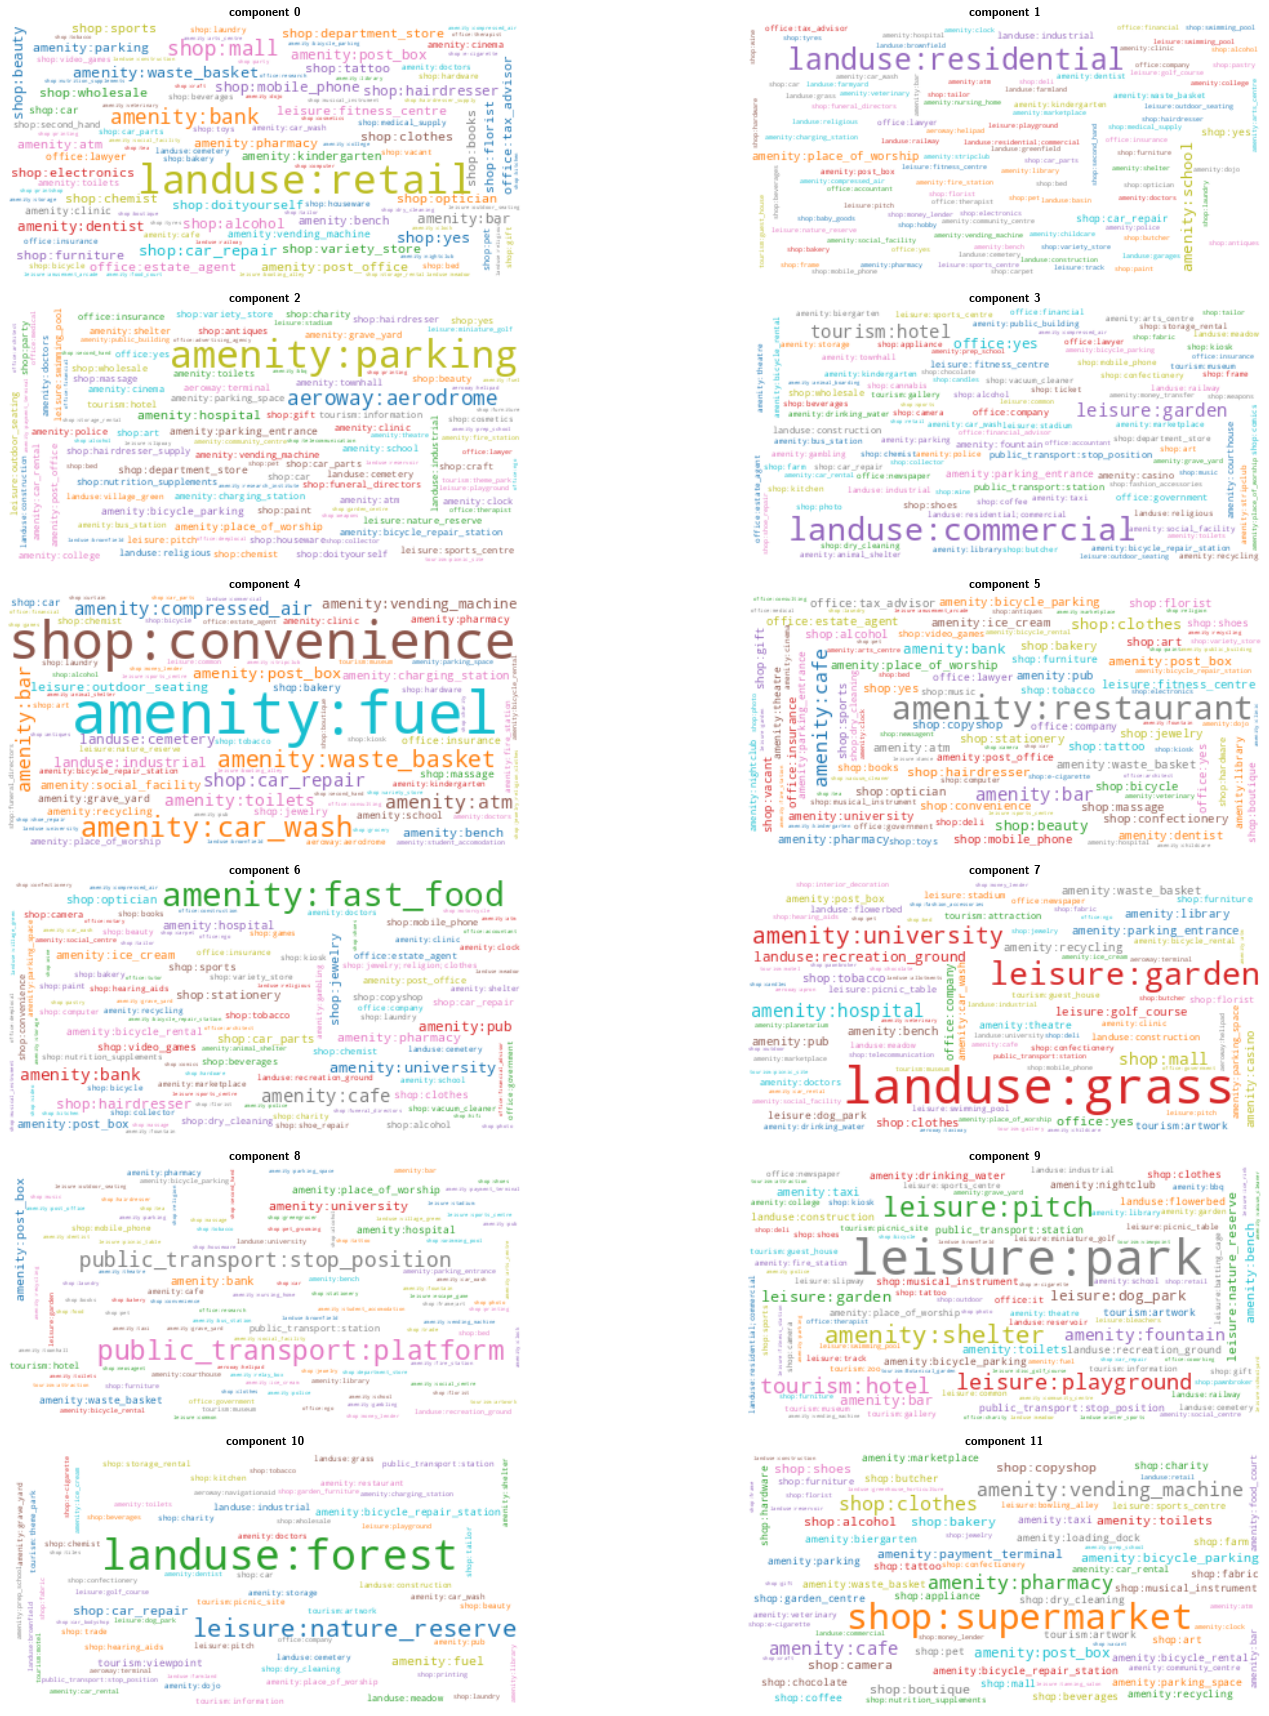

In [31]:
fig, axes = plt.subplots(len(components)//2, 2, figsize=(24, 24))
from wordcloud import WordCloud
for i, ax in enumerate(axes.flatten()):
    wc = WordCloud(background_color="white", max_words=100, colormap="tab10")
    wc.generate_from_frequencies(components.loc[i].to_dict())
    ax.imshow(wc, interpolation='bilinear')
    ax.set(title=f"component {i}")
    ax.axis("off")
plt.tight_layout()

In [32]:
import yaml
with open("tag-aggregates.yml") as fp:
    tag_aggs = yaml.safe_load(fp)

In [33]:
tag_cats = []
for group, tags in tag_aggs["tag_aggregates"].items():
    tag_cats.append(
        all_stop_tags[tags].sum(axis=1)
                           .clip(0, 1)
                           .rename(group)
    )
stop_cats = pd.concat(tag_cats, axis=1)
stop_cats.columns = stop_cats.columns.rename("category")
stop_cats

category                                         housing  education  \
driver_id                            stop_count                       
01077008-15a7-44a1-a712-b67e09735380 1.0             1.0        0.0   
                                     2.0             1.0        0.0   
019c9f85-3818-42de-bad6-d556e7ad1949 1.0             0.0        0.0   
                                     2.0             0.0        0.0   
                                     3.0             0.0        0.0   
...                                                  ...        ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1774.0          1.0        0.0   
                                     1775.0          1.0        0.0   
                                     1776.0          1.0        0.0   
                                     1777.0          0.0        0.0   
                                     1778.0          0.0        0.0   

category                                         youth_and_families  \
driver_id                            stop_count                       
01077008-15a7-44a1-a712-b67e09735380 1.0                        0.0   
                                     2.0                        0.0   
019c9f85-3818-42de-bad6-d556e7ad1949 1.0                        0.0   
                                     2.0                        0.0   
                                     3.0                        0.0   
...                                                             ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1774.0                     0.0   
                                     1775.0                     0.0   
                                     1776.0                     0.0   
                                     1777.0                     0.0   
                                     1778.0                     0.0   

category                                         healthcare  \
driver_id                            stop_count               
01077008-15a7-44a1-a712-b67e09735380 1.0                0.0   
                                     2.0                0.0   
019c9f85-3818-42de-bad6-d556e7ad1949 1.0                0.0   
                                     2.0                0.0   
                                     3.0                0.0   
...                                                     ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1774.0             0.0   
                                     1775.0             0.0   
                                     1776.0             0.0   
                                     1777.0             0.0   
                                     1778.0             0.0   

category                                         outdoor_recreation  \
driver_id                            stop_count                       
01077008-15a7-44a1-a712-b67e09735380 1.0                        0.0   
                                     2.0                        0.0   
019c9f85-3818-42de-bad6-d556e7ad1949 1.0                        0.0   
                                     2.0                        0.0   
                                     3.0                        0.0   
...                                                             ...   
ffb3c2d0-67b4-4163-be9d-eca9e7299377 1774.0                     0.0   
                                     1775.0                     0.0   
                                     1776.0                     0.0   
                                     1777.0                     0.0   
                                     1778.0                     0.0   

category                                         food_and_drink  \
driver_id                            stop_count                   
01077008-15a7-44a1-a712-b67e09735380 1.0                    0.0   
                                     2.0                    0.0   
019c9f85-3818-42de-bad6-d556e7ad1949 1.0                    0.0   
                                     2.0                    0.0   
      

In [34]:
stop_cats_ts = (
    stop_cats.join(service_stops.localtime_start)
             .set_index("localtime_start", append=True)
             .sort_index(level="localtime_start")
)

In [35]:
def test_nsm(st, l=1):
    centers = st.expanding().mean()
    deviations = st - centers
    cumulative_deviaitons  = (st - centers).cumsum()
    variance = cumulative_deviaitons.diff().fillna(0.0)**2
    cumulative_variance = variance.cumsum()
    t = l * cumulative_deviaitons - (l**2)/2.0 * cumulative_variance
    return t

def p_value(st, l=1):
    t = test_nsm(st, l)
    return np.exp(-t.max())

In [36]:
driver_stop_counts = stop_tags.groupby("driver_id").size()
driver_ids = driver_stop_counts[driver_stop_counts >= 100].index
len(driver_ids)

250

In [37]:
alpha = 0.01 / 2.0

## Stop categories

In [38]:
p_values = stop_cats.loc[driver_ids].groupby("driver_id").agg(p_value)

In [39]:
corrected_alpha = alpha / p_values.size

In [40]:
p_values_long = p_values.unstack() 
significant = p_values_long <= corrected_alpha

In [41]:
print(f"Found {significant.sum()} significant variables (out of {significant.size})")

Found 22 significant variables (out of 5750)


In [42]:
((p_values.size * p_values_long[p_values_long <= corrected_alpha]).sort_values()
 .rename("p_value")
 .to_frame()
 .reset_index()
 .drop(columns="driver_id").set_index("category")
 .groupby("category").agg(p_value=("p_value","min"), multiple=("p_value", "count")).sort_values("p_value")
)

,p_value,multiple
category,,
food_and_drink,3.050365e-42,3
outdoor_recreation,1.163475e-19,1
education,1.605375e-14,1
airport,1.797295e-13,4
housing,9.714096e-13,6
end_of_life,1.178933e-12,1
commercial,4.745877e-07,3
outdoor_activities,2.358043e-06,1
indoor_activities,4.956049e-05,1


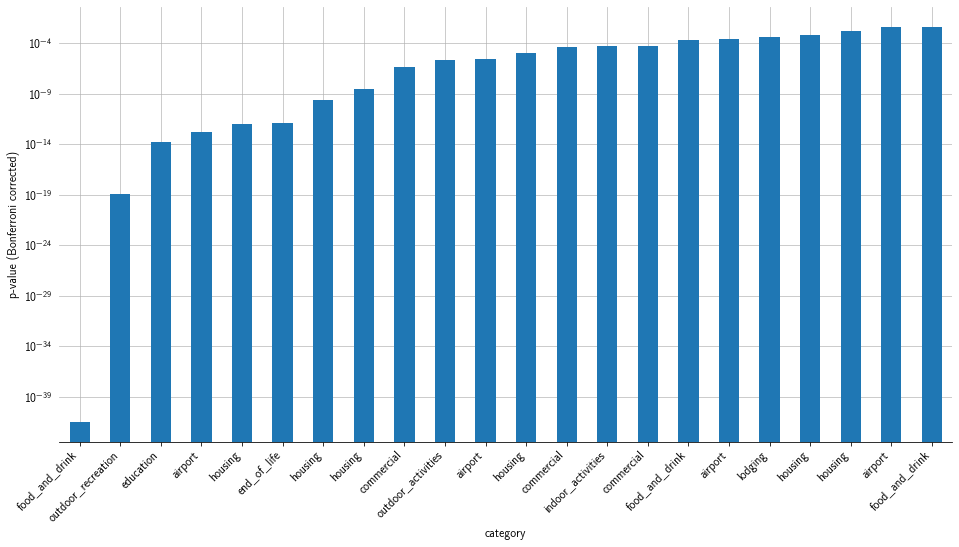

In [43]:
fig, ax = plt.subplots(figsize=(16, 8))
(p_values_long[significant].sort_values(ascending=True).reset_index("driver_id", drop=True) * p_values.size).plot(ax=ax, kind="bar")
ax.set_yscale("log")
ax.set_ylabel("p-value (Bonferroni corrected)")
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

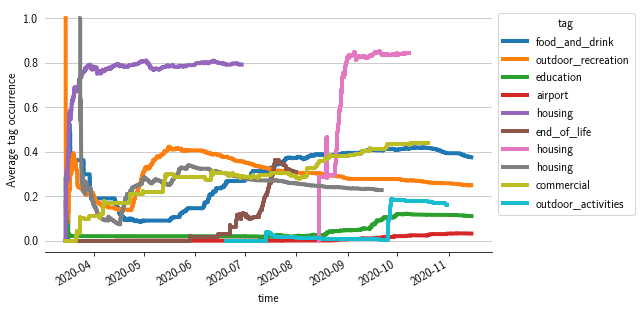

In [44]:
fig, ax = plt.subplots()
width=6
height=4
for (tag, driver_id), p_val in p_values_long[p_values_long <= corrected_alpha].sort_values().head(10).iteritems():
    _df = stop_cats_ts.loc[driver_id, [tag]].reset_index("stop_count", drop=True).expanding().mean().iloc[::2]
    _df[tag].plot(drawstyle="steps",)
legend_out(ax, title="tag")
ax.grid(False, axis="x")
ax.set(xlabel="time", ylabel="Average tag occurrence")
#tpl.clean_figure(fig)
#tpl.save("avg-sig-tag-occurrence-over-time.tex", figure=fig, axis_width=f"{width}in", axis_height=f"{height}in")

## Selected Tags

In [45]:
p_values = stop_tags.loc[driver_ids].groupby("driver_id").agg(p_value)

In [46]:
corrected_alpha = alpha / p_values.size

In [47]:
p_values_long = p_values.unstack() 
significant = p_values_long <= corrected_alpha

In [48]:
print(f"Found {significant.sum()} significant variables (out of {significant.size})")

Found 22 significant variables (out of 96750)


In [49]:
((p_values.size * p_values_long[p_values_long <= corrected_alpha]).sort_values()
 .rename("p_value")
 .to_frame()
 .reset_index()
 .drop(columns="driver_id").set_index("tag")
 .groupby("tag").agg(p_value=("p_value","min"), multiple=("p_value", "count")).sort_values("p_value")
)

,p_value,multiple
tag,,
amenity:restaurant,1.111958e-44,2
landuse:residential,1.914568e-32,3
leisure:park,3.563340e-26,1
amenity:college,1.272886e-21,1
amenity:parking_space,1.115668e-20,1
aeroway:aerodrome,3.024144e-12,3
amenity:grave_yard,8.230540e-11,1
landuse:construction,1.269627e-07,1
landuse:retail,2.934202e-06,2


In [50]:
p_values.size

96750

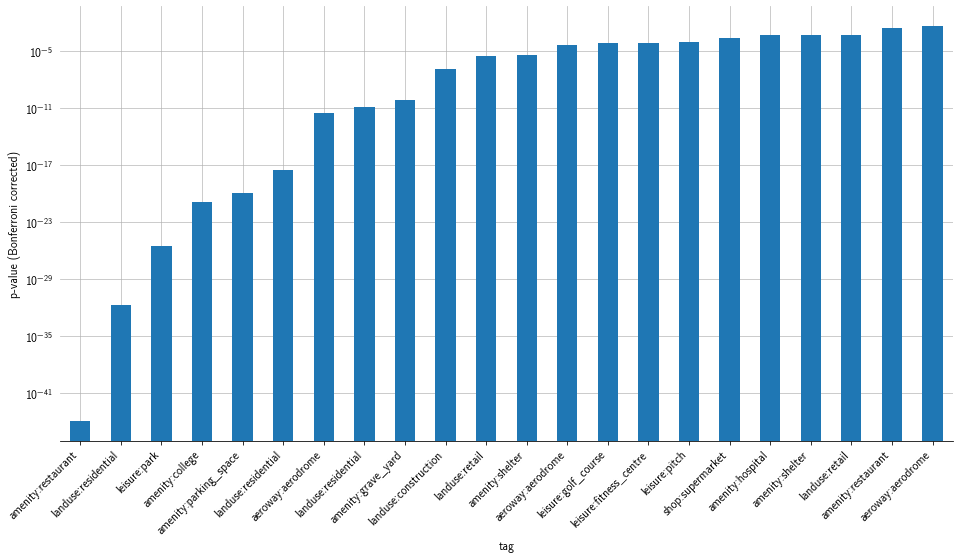

In [51]:
fig, ax = plt.subplots(figsize=(16, 8))
(p_values_long[significant].sort_values(ascending=True).reset_index("driver_id", drop=True) * p_values.size).plot(ax=ax, kind="bar")
ax.set_yscale("log")
ax.set_ylabel("p-value (Bonferroni corrected)")
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

In [52]:
p_values_long[p_values_long <= corrected_alpha].sort_values().head(10)

tag                    driver_id                           
amenity:restaurant     4918bd52-4031-447e-90f4-6655fa393d96    1.149311e-49
landuse:residential    9309a3d8-6dbc-4de8-baeb-d95f1849aca4    1.978881e-37
leisure:park           b3f17f65-7c93-4ae2-9ba1-40a69f067262    3.683038e-31
amenity:college        79405279-c433-4a77-bef7-7ab638a3332f    1.315645e-26
amenity:parking_space  a33877db-3363-4ba8-a529-f5825ef1f17f    1.153145e-25
landuse:residential    c45c6fb3-119c-41ad-aeda-be1597271edf    3.146753e-23
aeroway:aerodrome      e5e5201e-f307-43a6-b9f5-77feecfda53e    3.125730e-17
landuse:residential    24bdf186-2155-426e-be48-b722ff50ef07    1.454032e-16
amenity:grave_yard     f99732df-d75c-419b-9978-7e254f5e9d2c    8.507018e-16
landuse:construction   c07a18b3-7c06-4e5f-8d41-b9722d7ead5a    1.312276e-12
dtype: float64

In [54]:
p_values_neg = (-stop_tags).loc[driver_ids].groupby("driver_id").agg(p_value)
p_values_neg_long = p_values_neg.unstack()
significant_neg = p_values_neg_long <= corrected_alpha
p_values_neg_long[significant_neg].sort_values(ascending=True).head(20)

tag                       driver_id                           
landuse:retail            4918bd52-4031-447e-90f4-6655fa393d96    3.296668e-115
aeroway:aerodrome         733e2b4a-74f3-4cae-ac0a-b68fe84c0382     1.387118e-84
amenity:parking           4918bd52-4031-447e-90f4-6655fa393d96     2.347539e-49
aeroway:aerodrome         55dac7f0-30ab-4e6d-b49a-9c87893e2c70     1.495939e-47
tourism:hotel             d3bee377-485a-4e2d-af7b-2c73c439b9dd     7.219243e-42
amenity:parking           55dac7f0-30ab-4e6d-b49a-9c87893e2c70     1.493065e-37
aeroway:aerodrome         69cebffb-b95e-4ba3-893d-a5e16e9eefd1     7.346626e-32
amenity:charging_station  d3bee377-485a-4e2d-af7b-2c73c439b9dd     9.667314e-31
aeroway:aerodrome         3eae1b15-3497-4f8b-82ee-cdf5a663680e     6.573465e-29
landuse:residential       fb6f4972-06d9-4f7a-96e0-02850dde0aef     2.093909e-28
aeroway:aerodrome         d909cfec-4107-45f0-b18f-042ba5e051ad     3.469514e-27
                          7d3aa406-f51b-49e5-86dc-71ee0e2

In [55]:
significant_neg.sum()

72

In [56]:
p_values_summary = (
    (p_values_long).groupby("tag")
                 .min()
                 .clip(None, 1)
                 .rename("best p value (+)")
                 .to_frame()
                 .join(significant.groupby("tag").sum().rename("n significant (+)"))
).join(
    (p_values_neg_long).groupby("tag")
                 .min()
                 .clip(None, 1)
                 .rename("best p value (-)")
                 .to_frame()
                 .join(significant_neg.groupby("tag").sum().rename("n significant (-)"))
)
with pd.option_context("display.max_rows", None, 'display.float_format',  '{:g}'.format):
    display(p_values_summary)

,best p value (+),n significant (+),best p value (-),n significant (-)
tag,,,,
aeroway:aerodrome,3.12573e-17,3,1.38712e-84,20
aeroway:apron,0.0170965,0,1.87998e-05,0
aeroway:gate,0.0238102,0,4.56573e-05,0
aeroway:hangar,0.606531,0,0.805221,0
aeroway:helipad,0.0302891,0,3.44076e-06,0
aeroway:navigationaid,0.286244,0,0.340138,0
aeroway:parking_position,0.0238102,0,4.56573e-05,0
aeroway:runway,0.606531,0,0.102955,0
aeroway:taxiway,0.232046,0,0.0234542,0


In [57]:
with pd.option_context("display.max_rows", None):
    _df = (p_values.size * p_values_neg_long[p_values_neg_long <= corrected_alpha].sort_values()
            .rename("p_value")
            .to_frame()
            .reset_index()
            .drop(columns="driver_id")
            .set_index("tag")
            )
    display(_df.groupby("tag").agg(p_value=("p_value","min"), multiple=("p_value", "count")).sort_values("p_value"))

,p_value,multiple
tag,,
landuse:retail,3.189526e-110,1
aeroway:aerodrome,1.342037e-79,20
amenity:parking,2.271244e-44,7
tourism:hotel,6.984617e-37,2
amenity:charging_station,9.353126e-26,3
landuse:residential,2.025857e-23,2
shop:supermarket,1.770059e-17,5
amenity:casino,8.393449e-16,1
landuse:grass,1.280746e-14,2


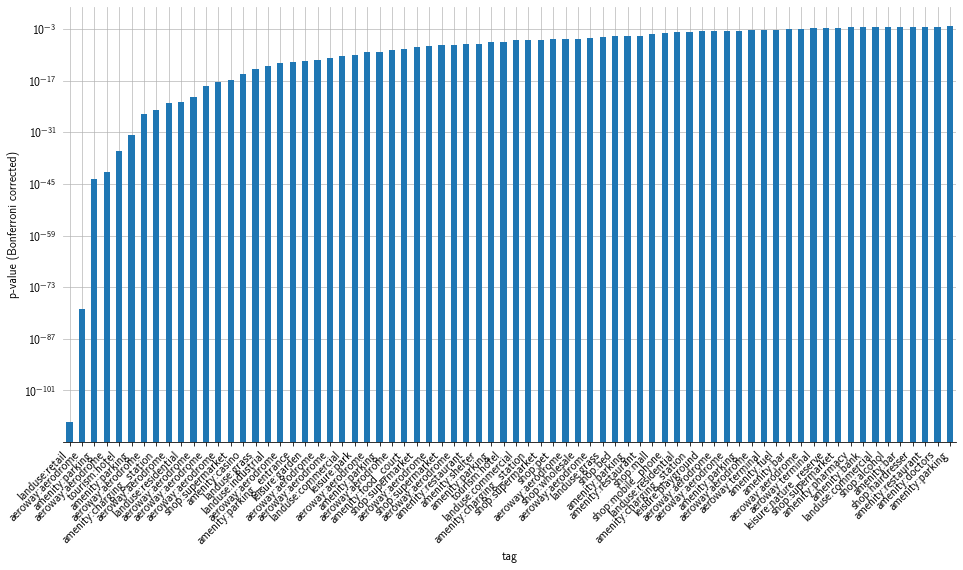

In [58]:
fig, ax = plt.subplots(figsize=(16, 8))
(p_values_neg_long[significant_neg].sort_values(ascending=True).reset_index("driver_id", drop=True) * p_values.size).plot(ax=ax, kind="bar")
ax.set_yscale("log")
ax.set_ylabel("p-value (Bonferroni corrected)")
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

In [60]:
stop_tags_ts = (
    stop_tags.join(service_stops.localtime_start)
             .set_index("localtime_start", append=True)
             .sort_index(level="localtime_start")
)

In [61]:
stop_tags_ts

,,,aeroway:aerodrome,aeroway:apron,aeroway:gate,aeroway:hangar,aeroway:helipad,aeroway:navigationaid,aeroway:parking_position,aeroway:runway,aeroway:taxiway,aeroway:terminal,...,tourism:guest_house,tourism:hostel,tourism:hotel,tourism:information,tourism:motel,tourism:museum,tourism:picnic_site,tourism:theme_park,tourism:viewpoint,tourism:zoo
driver_id,stop_count,localtime_start,,,,,,,,,,,,,,,,,,,,,
d3490d02-7d1c-49f1-b325-80d173afeb90,1.0,2020-03-14 20:00:02.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6dda506a-11c6-4751-b26f-460b380dedeb,1.0,2020-03-14 20:00:04.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e48d92fc-af6e-4bf9-801a-6a051be929cb,1.0,2020-03-14 20:00:31.122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95861b97-3b42-4ba5-b0d6-c30c9cfe8db7,1.0,2020-03-14 20:00:34.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8814aedc-24e0-4238-a47f-0e7c23b4c311,1.0,2020-03-14 20:00:48.044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79405279-c433-4a77-bef7-7ab638a3332f,2276.0,2020-11-14 18:54:12.924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71c909b4-2431-4c40-a2a1-ebe231ee46cb,1048.0,2020-11-14 18:54:45.997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2b151af3-e423-4df6-89c2-504009a1f953,2122.0,2020-11-14 18:54:46.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


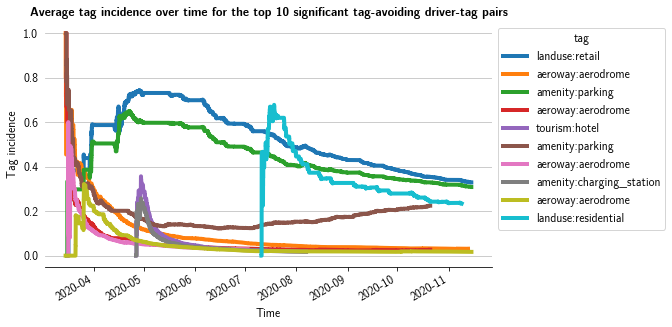

In [67]:
fig, ax = plt.subplots()
width=5
height=3
for (tag, driver_id), p_val in p_values_neg_long[p_values_neg_long <= corrected_alpha].sort_values().head(10).iteritems():
    _df = stop_tags_ts.loc[driver_id, [tag]].reset_index("stop_count", drop=True).expanding().mean().iloc[::2]
    _df[tag].plot(drawstyle="steps",)
legend_out(ax, title="tag")
ax.grid(False, axis="x")
ax.set(
    xlabel="Time",
    ylabel="Tag incidence",
    title="Average tag incidence over time for the top 10 significant tag-avoiding driver-tag pairs")
#tpl.clean_figure(fig)
#tpl.save("avg-sig-neg-tag-occurrence-over-time.tex", figure=fig, axis_width=f"{width}in", axis_height=f"{height}in")
fig.savefig("figures/sig-avoid-tag-prob-over-time.png", bbox_inches="tight")

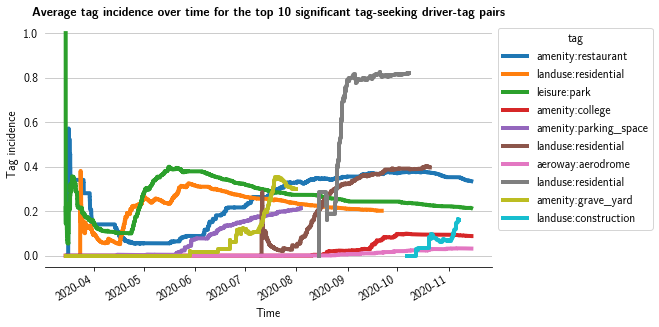

In [68]:
fig, ax = plt.subplots()
width=6
height=4
for (tag, driver_id), p_val in p_values_long[p_values_long <= corrected_alpha].sort_values().head(10).iteritems():
    _df = stop_tags_ts.loc[driver_id, [tag]].reset_index("stop_count", drop=True).expanding().mean().iloc[::2]
    _df[tag].plot(drawstyle="steps",)
legend_out(ax, title="tag")
ax.grid(False, axis="x")
ax.set(
    xlabel="Time",
    ylabel="Tag incidence",
    title="Average tag incidence over time for the top 10 significant tag-seeking driver-tag pairs")
#tpl.clean_figure(fig)
#tpl.save("avg-sig-tag-occurrence-over-time.tex", figure=fig, axis_width=f"{width}in", axis_height=f"{height}in")
fig.savefig("figures/sig-seek-tag-prob-over-time.png", bbox_inches="tight")

In [ ]:
agg_p_values_neg = p_value(-stop_tags_ts)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
(agg_p_values_neg[agg_p_values_neg <= alpha / agg_p_values.size].sort_values() * agg_p_values.size).plot(ax=ax, kind="bar")
ax.set_yscale("log")
ax.set_ylabel("p-value (Bonferroni corrected)")
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

In [ ]:
cols = agg_p_values_neg[agg_p_values_neg <= alpha / agg_p_values.size].sort_values().head(10).index.to_list()

fig, ax = plt.subplots()
stop_tags_ts[cols].reset_index(["driver_id", "stop_count"], drop=True).sort_index().expanding().mean().plot( ax=ax, legend=False)
legend_out(ax)
#ax.set_yscale("log")

In [ ]:
agg_p_values = p_value(stop_tags_ts)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
(agg_p_values[agg_p_values < alpha / agg_p_values.size].sort_values() * agg_p_values.size).plot(ax=ax, kind="bar")
ax.set_yscale("log")
ax.set_ylabel("p-value (Bonferroni corrected)")
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

In [ ]:
cols = ["amenity:college"] #agg_p_values[agg_p_values < alpha / agg_p_values.size].index.to_list()

fig, ax = plt.subplots()
stop_tags_ts[cols].reset_index(["driver_id", "stop_count"], drop=True).sort_index().expanding().mean().plot( ax=ax, legend=False)
legend_out(ax)